# Dog Breed

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogbreed/"
sz = 300
arch = inception_4
bs = 64 

In [4]:
get_cv_idxs

<function fastai.dataset.get_cv_idxs>

In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = [0]
#get_cv_idxs(n)

## Initial exploration

In [6]:
!ls {PATH}

labels.csv  sample_submission.csv  test  tmp  train


In [7]:
files = !ls {PATH}test/ | head
files

['000621fb3cbb32d8935728e48679680e.jpg',
 '00102ee9d8eb90812350685311fe5890.jpg',
 '0012a730dfa437f5f3613fb75efcd4ce.jpg',
 '001510bc8570bbeee98c8d80c8a95ec1.jpg',
 '001a5f3114548acdefa3d4da05474c2e.jpg',
 '00225dcd3e4d2410dd53239f95c0352f.jpg',
 '002c2a3117c2193b4d26400ce431eebd.jpg',
 '002c58d413a521ae8d1a5daeb35fc803.jpg',
 '002f80396f1e3db687c5932d7978b196.jpg',
 '0036c6bcec6031be9e62a257b1c3c442.jpg']

In [8]:
label_df = pd.read_csv(label_csv)

In [9]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', tfms=tfms, val_idxs=val_idxs, test_name='test',
                                   suffix='.jpg', bs=bs)

In [12]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

In [13]:
img = PIL.Image.open(fn)

In [14]:
img.size

(500, 375)

In [15]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [16]:
row_sz, col_sz = list(zip(*size_d.values()))

In [17]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [18]:
row_sz[:5]

array([500, 500, 400, 500, 500])

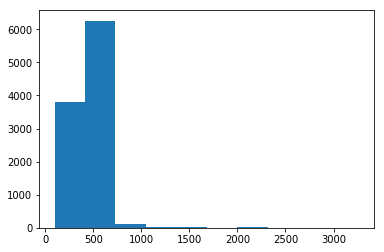

In [19]:
plt.hist(row_sz);

(array([  178.,   762.,  1671.,  1486.,  5704.,   155.,    98.,    72.,    15.,    12.]),
 array([  97. ,  186.3,  275.6,  364.9,  454.2,  543.5,  632.8,  722.1,  811.4,  900.7,  990. ]),
 <a list of 10 Patch objects>)

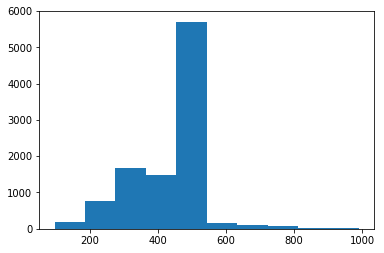

In [20]:
plt.hist(row_sz[row_sz<1000])

(array([ 3595.,  6394.,   150.,    28.,    18.,    20.,    10.,     3.,     0.,     3.]),
 array([  102.,   348.,   594.,   840.,  1086.,  1332.,  1578.,  1824.,  2070.,  2316.,  2562.]),
 <a list of 10 Patch objects>)

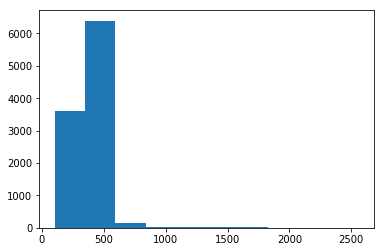

In [21]:
plt.hist(col_sz)

(array([  302.,   910.,  2781.,  3684.,  2273.,   115.,    33.,    39.,     9.,    11.]),
 array([ 102. ,  190.2,  278.4,  366.6,  454.8,  543. ,  631.2,  719.4,  807.6,  895.8,  984. ]),
 <a list of 10 Patch objects>)

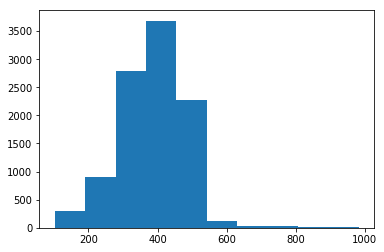

In [22]:
plt.hist(col_sz[col_sz<1000])

In [23]:
len(data.trn_ds), len(data.test_ds)

(10221, 10357)

In [24]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial Model

In [25]:
def get_data(sz, bs):
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', tfms=tfms, val_idxs=val_idxs, test_name='test',
                                        suffix='.jpg', bs=bs, num_workers=4)
    return data if sz > 300 else data.resize(340, 'tmp')

In [26]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

100%|██████████| 162/162 [08:14<00:00,  3.05s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.56748  0.00941  1.     ]                        



In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████▎| 149/160 [00:09<00:00, 16.44it/s, loss=12.6]


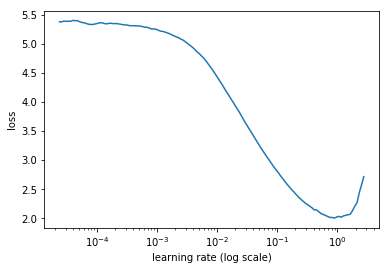

In [29]:
learn.sched.plot()

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-1, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.54942  0.01116  1.     ]                        



In [ ]:
learn.fit(1e-1, 2)

## Augment

In [ ]:
from sklearn import metrics

In [ ]:
data = get_data(sz, bs)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
#learn.fit(1e-1, 2)

In [ ]:
learn.precompute = False

In [ ]:
learn.fit(1e-1, 3, cycle_len=1)

In [ ]:
learn.save('224_pre')

In [ ]:
learn.load('224_pre')

## Increase Size

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(1e-2, 3, cycle_len=1, cycle_mult = 2)

In [ ]:
learn.set_data(get_data(350, bs))

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult = 2)

In [45]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds, y), metrics.log_loss(y, probs)

ValueError: y_true contains only one label (19). Please provide the true labels explicitly through the labels argument.

In [ ]:
learn.save('350_mul_pre')

In [ ]:
learn.load('350_mul_pre')

In [31]:
test_preds = learn.TTA(is_test=True)

In [32]:
test_preds = np.exp(test_preds[0])

In [33]:
test_preds.shape

(10357, 120)

In [ ]:
data.test_dl.dataset.fnames

In [ ]:
test_preds

In [34]:
filenames = data.test_dl.dataset.fnames

In [35]:
ids = [f[5:f.find('.')] for f in filenames]

In [36]:
sub = pd.DataFrame(test_preds)

In [37]:
col_names = data.classes

In [38]:
sub.columns = col_names

In [39]:
sub.head(5)

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,2.388289e-07,2.344623e-07,1.105870e-07,9.992211e-01,6.738200e-08,3.694612e-07,4.795124e-07,1.152768e-06,1.374053e-07,3.709879e-07,...,2.213378e-07,5.630141e-07,1.032539e-07,1.319406e-07,2.761439e-07,5.251087e-07,1.150063e-07,5.869835e-08,2.994015e-05,5.813701e-08
1,9.995309e-01,1.176899e-07,2.572151e-07,2.685962e-06,4.256030e-07,2.135057e-06,9.395948e-07,1.387175e-06,2.429877e-07,2.610943e-07,...,3.308594e-06,2.044754e-06,1.314141e-07,2.202202e-07,1.924093e-07,5.447254e-07,2.887379e-06,1.123012e-06,6.773587e-07,7.147944e-05
2,1.753415e-08,1.136987e-07,2.671154e-09,5.914358e-09,1.190557e-07,1.299815e-08,2.197603e-07,1.013294e-08,1.177521e-07,4.422499e-09,...,3.526565e-08,4.680305e-08,3.065195e-08,2.033446e-08,6.755457e-08,4.753982e-08,1.326395e-08,2.309555e-08,7.856091e-07,2.534863e-07
3,2.816625e-04,1.760892e-06,1.823074e-05,2.717294e-06,5.266331e-06,2.322616e-06,4.290215e-06,7.299029e-06,3.760627e-06,5.183675e-06,...,2.702023e-05,1.339379e-05,2.294845e-06,5.411978e-06,3.174276e-06,2.126279e-06,8.787272e-06,2.906689e-06,3.419851e-06,3.900070e-05
4,8.903433e-07,1.519182e-05,1.579953e-05,1.366232e-05,7.667593e-07,5.114020e-07,3.858320e-06,1.523386e-06,2.836010e-06,4.093057e-06,...,4.151578e-06,3.551856e-06,6.392645e-06,5.117182e-07,7.111944e-06,3.544736e-06,9.872134e-07,1.611716e-06,2.479551e-05,2.144797e-06


In [40]:
sub.insert(0, 'id', ids)

In [41]:
sub.tail(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
10352,010a0d3eb52479f4af474662ee0f67ee,2.233254e-05,4.483965e-05,3.072618e-06,1.084400e-04,2.592176e-05,1.142850e-04,1.651166e-02,1.575242e-05,1.037062e-05,...,2.198676e-05,5.253086e-05,2.380519e-05,3.158646e-06,4.421439e-06,7.440065e-06,2.094150e-05,2.613846e-06,3.543168e-04,8.206101e-01
10353,10630ca7791c65508f5a460f43c90de7,3.283816e-07,4.585149e-07,1.281200e-07,7.385148e-07,1.626042e-08,5.172631e-07,9.772732e-08,2.428158e-07,1.263128e-06,...,1.249666e-06,3.038795e-07,2.419024e-07,2.120319e-06,5.507119e-07,8.006864e-08,1.546999e-05,1.039697e-07,3.594769e-08,1.562566e-07
10354,233c3979613d43bf3fd22273ac3bf619,1.516838e-04,9.140394e-06,3.974200e-06,8.798736e-06,5.138219e-07,7.876556e-07,1.130067e-05,7.145072e-06,8.262774e-07,...,8.001849e-06,1.885664e-06,4.029803e-06,1.030326e-06,1.148057e-06,9.625006e-07,4.907777e-04,4.349631e-07,7.699450e-06,7.717218e-06
10355,fb2cb63322ef0e9a7ade9ecd93921eb2,3.807050e-06,8.730825e-07,1.459643e-06,1.403046e-06,6.601746e-07,4.268906e-04,2.895768e-06,3.614727e-07,2.168060e-07,...,1.520487e-06,1.341202e-07,1.063625e-06,4.398319e-07,7.966104e-07,2.606535e-06,1.699361e-06,1.234847e-07,2.389739e-06,5.440152e-07
10356,049d9283a00a92897209b746362ae0a4,8.865406e-07,4.057542e-08,2.358692e-06,3.643312e-06,5.184726e-07,3.131345e-07,1.699506e-07,1.525042e-07,2.817975e-07,...,6.658602e-07,7.067232e-08,3.552833e-05,1.482225e-06,5.007680e-05,5.803692e-06,1.120421e-07,2.761539e-07,6.921807e-08,1.046064e-07


In [43]:
sub.to_csv(f'{PATH}results/submission4.csv', index=False)